# Analyse de données : Projet informatique

In [2]:
!python --version

Python 3.10.12


In [35]:
#!pip install -r requirements.txt
#!pip install --upgrade pip
!pip list | grep pandas

pandas            2.2.3


### Imports

In [ ]:
import pandas as pd
from pathlib import Path
from typing import Union
import plotly.express as px

In [16]:
def read_data(datapath: Union[str, Path]):
    datapath = Path(datapath)
    assert datapath.is_file(), "Your file does not exist"
    if datapath.suffix == ".xlsx":
        df = pd.read_excel(datapath)
    elif datapath.suffix == ".csv":
        df1 = pd.read_csv(datapath, sep=",", nrows=2)
        df2 = pd.read_csv(datapath, sep=";", nrows=2)
        if len(df1.columns) > len(df2.columns):
            df = pd.read_csv(datapath, sep=",")
        if len(df2.columns) > len(df1.columns):
            df = pd.read_csv(datapath, sep=";")
        elif len(df1.columns) == len(df2.columns):
            raise ValueError("Cannot read the .csv file (No matching separator)")
    else:
        raise ValueError("Cannot read the file (Unknown format)")

    return df


# Main Path
DATA_PATH = Path("data/cars24data.csv")

df = read_data(DATA_PATH)
df.head()

,Model Name,Price,Manufacturing_year,Engine capacity,Spare key,Transmission,KM driven,Ownership,Fuel type,Imperfections,Repainted Parts
0,2017 Maruti Swift VXI,561000,2017,1197,No,Manual,25847,2,Petrol,6,2
1,2016 Maruti Baleno DELTA PETROL 1.2,498000,2016,1197,Yes,Manual,55511,2,Petrol,12,1
2,2020 Maruti Swift VXI,577000,2020,1197,No,Manual,47110,1,Petrol,4,2
3,2022 Maruti Ertiga VXI AT SHVS,1084000,2022,1462,Yes,Automatic,35378,1,Petrol,2,3
4,2019 Maruti Dzire VXI,603000,2019,1197,Yes,Manual,91856,1,Petrol,3,2


In [ ]:
# 1) On veux une table décrivant les modèles
print(df[["Model Name"]].drop_duplicates().shape)
print(
    df[
        [
            "Model Name",
            "Manufacturing_year",
            "Engine capacity",
            "Fuel type",
            "Transmission",
        ]
    ]
    .drop_duplicates()
    .shape
)

(573, 1)
(584, 5)


In [24]:
# Ici, on a des dupliqués (différence de taille). Essayons de comprendre quelle colonne(s) provoque(nt) ce phénomène
for col in ("Manufacturing_year", "Engine capacity", "Fuel type", "Transmission"):
    print(col, " -->", df[["Model Name", col]].drop_duplicates().shape)

Manufacturing_year  --> (573, 2)
Engine capacity  --> (574, 2)
Fuel type  --> (583, 2)
Transmission  --> (573, 2)


In [25]:
# On a 573 noms de modèles différents, ici, on remarque que pour un modèle,
# - L'année et la transmission sont toujours les mêmes
# - Les caractéristiques du moteur peuvent changer
# Ex:
df[["Model Name", "Engine capacity", "Fuel type"]].drop_duplicates().sort_values(
    by="Model Name"
)

,Model Name,Engine capacity,Fuel type
1126,2010 Maruti A Star LXI,998,Petrol
44,2011 Maruti Alto K10 VXI,998,Petrol
814,2011 Maruti Ritz LXI,1197,Petrol
1082,2011 Maruti Ritz VDI,1248,Diesel
784,2011 Maruti Ritz VXI,1197,Petrol
...,...,...,...
919,2023 Maruti S PRESSO VXI+,998,Petrol
878,2023 Maruti Swift LXI,1197,Petrol
828,2023 Maruti Swift VXI,1197,Petrol
245,2023 Maruti XL6 ALPHA PLUS MT,1462,Petrol


In [26]:
# Verifions rapidement le nombre de possibilités pour mon couple moteur (Capacité + type d'essence).
# Peut être que les caractéristiques moteurs peuvent constituer une table à part entière.
df[["Engine capacity", "Fuel type"]].drop_duplicates()

,Engine capacity,Fuel type
0,1197,Petrol
3,1462,Petrol
5,796,Petrol
9,998,Petrol
34,1248,Diesel
53,1248,Petrol
75,998,CNG
112,1373,Petrol
243,1462,CNG
265,796,CNG


In [ ]:
# Bingo, on a que 10 moteurs différents !!!!!

In [28]:
# 2) Création de tables

# Moteur
df_motor = df[["Engine capacity", "Fuel type"]].drop_duplicates()
df_motor = df_motor.reset_index(drop=False)
df_motor = df_motor.rename(
    columns={
        "index": "id_motor",
        "Engine capacity": "engine_capacity",
        "Fuel type": "fuel_type",
    }
)
print(df_motor.shape)
df_motor.head()

(14, 3)


,id_motor,engine_capacity,fuel_type
0,0,1197,Petrol
1,3,1462,Petrol
2,5,796,Petrol
3,9,998,Petrol
4,34,1248,Diesel


In [30]:
# Chassis
df_frame = df[
    ["Model Name", "Manufacturing_year", "Transmission", "Engine capacity", "Fuel type"]
].drop_duplicates()
df_frame = df_frame.reset_index(drop=False)
df_frame = df_frame.rename(
    columns={
        "index": "id_frame",
        "Model Name": "model_name",
        "Manufacturing_year": "manufacturing_year",
        "Transmission": "transmission",
        "Engine capacity": "engine_capacity",
        "Fuel type": "fuel_type",
    }
)
df_frame = pd.merge(
    df_frame, df_motor, on=["engine_capacity", "fuel_type"], how="left", validate="m:1"
)
df_frame = df_frame.drop(["engine_capacity", "fuel_type"], axis=1)
print(df_frame.shape)
df_frame.head()

(584, 5)


,id_frame,model_name,manufacturing_year,transmission,id_motor
0,0,2017 Maruti Swift VXI,2017,Manual,0
1,1,2016 Maruti Baleno DELTA PETROL 1.2,2016,Manual,0
2,2,2020 Maruti Swift VXI,2020,Manual,0
3,3,2022 Maruti Ertiga VXI AT SHVS,2022,Automatic,3
4,4,2019 Maruti Dzire VXI,2019,Manual,0


In [32]:
# Vehicule
df_vehicule = df.reset_index(drop=False)
df_vehicule = df_vehicule.rename(
    columns={
        "index": "id_vehicule",
        "Model Name": "model_name",
        "Manufacturing_year": "manufacturing_year",
        "Transmission": "transmission",
        "Spare key": "spare_key",
        "KM driven": "km_driven",
        "Ownership": "ownership",
        "Imperfections": "imperfections",
        "Repainted Parts": "repainted_parts",
        "Engine capacity": "engine_capacity",
        "Fuel type": "fuel_type",
    }
)
df_vehicule = pd.merge(
    df_vehicule,
    df_motor,
    on=["engine_capacity", "fuel_type"],
    how="left",
    validate="m:1",
)
df_vehicule = pd.merge(
    df_vehicule,
    df_frame,
    on=["transmission", "manufacturing_year", "model_name", "id_motor"],
    how="left",
    validate="m:1",
)
df_vehicule = df_vehicule.drop(
    [
        "transmission",
        "manufacturing_year",
        "model_name",
        "engine_capacity",
        "fuel_type",
        "id_motor",
    ],
    axis=1,
)
print(df_vehicule.shape)
df_vehicule.head()

(1445, 8)


,id_vehicule,Price,spare_key,km_driven,ownership,imperfections,repainted_parts,id_frame
0,0,561000,No,25847,2,6,2,0
1,1,498000,Yes,55511,2,12,1,1
2,2,577000,No,47110,1,4,2,2
3,3,1084000,Yes,35378,1,2,3,3
4,4,603000,Yes,91856,1,3,2,4


In [40]:
mermaid_diagramm = """
```mermaid
erDiagram
    VEHICULE {
        int id_vehicule
        string spare_key
        int km_driven
        string ownership
        string imperfections
        string repainted_parts
        int id_frame
    }
    MOTOR {
        int id_motor
        string engine_capacity
        string fuel_type
    }
    FRAME {
        int id_frame
        string transmission
        int manufacturing_year
        string model_name
        int id_motor
    }

    FRAME ||--|{ VEHICULE : "via transmission + manufacturing_year + model_name + id_motor"
    MOTOR ||--|{ FRAME : "via id_motor"
```
"""

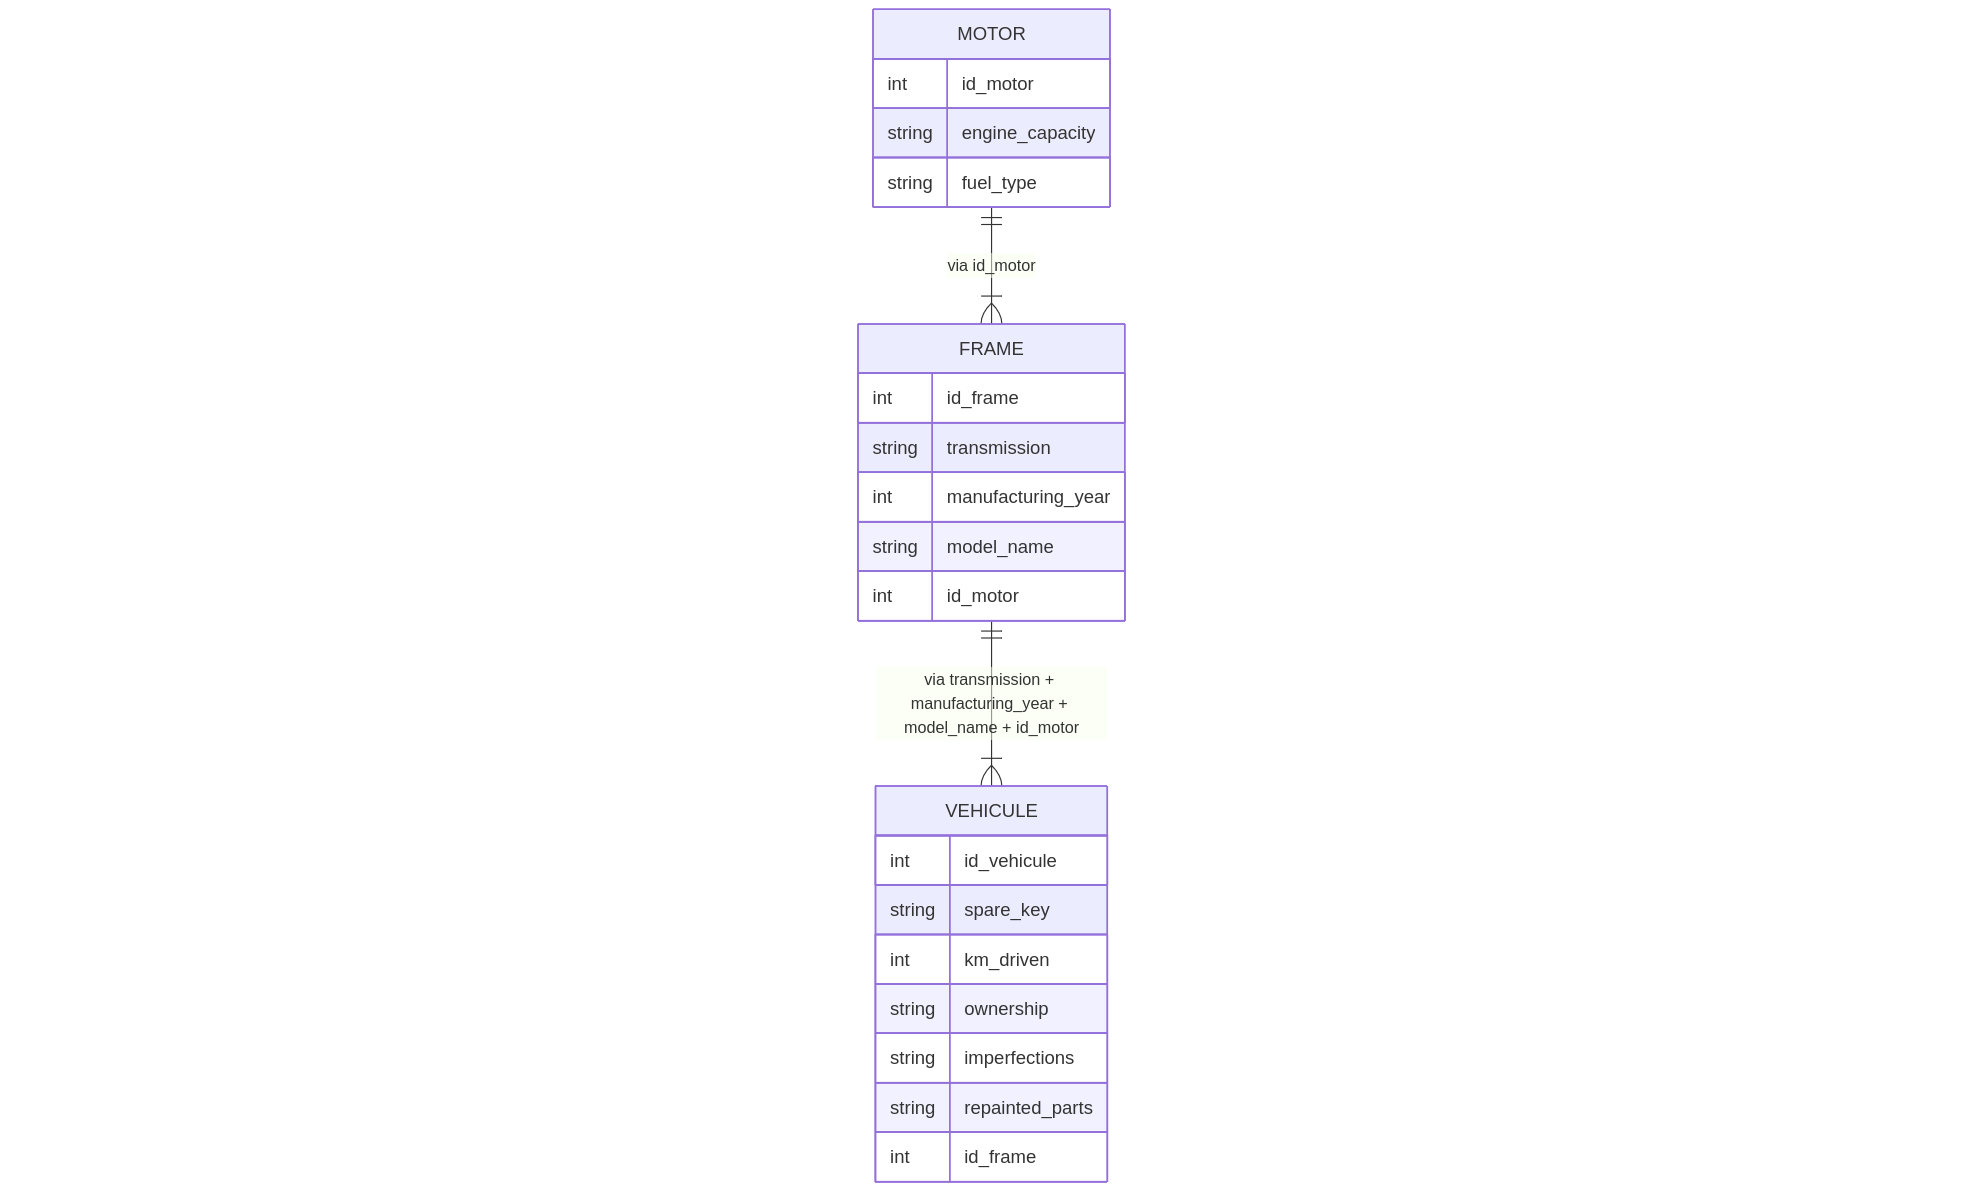

In [44]:
from IPython import display

display.Image("images/er_diagram.png")